## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Dependencies

In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
from moviepy.editor import VideoFileClip

## Functions

In [195]:
def show_img(img):
    """Simple helper function used to visualize output during development
    Takes an np.array image as input - returns nothing"""

    fig = plt.figure()
    fig.add_subplot(111)
    plt.imshow(img)
    plt.show()

def calibrateCam(rootpath="./camera_cal/", nx=9, ny=6):
    """calibrateCamera is called to perform calibration on a single camera once at the start of the script
    It acts on all files with a .jpg (case-sensitive) extension contained in rootpath. 
    All qualifying files are expected to have a minimum of nx and ny checkerboard intersections.
    nx and ny are the # of internal corners on checkerboard paper (not img)"""

    calImgPaths = [rootpath + i for i in os.listdir(rootpath) if i[-3:] == 'jpg']

    # For storage of image & object points (img points output of calibration calls)
    # objPts = np.meshgrid()
    imgPts = []
    objPts = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    lastImgSize = 0 # Used in error check for img.shape within loop

    # For each given image
    for path in calImgPaths:

        # Read as grayscale and find corners using fxn params
        img = cv2.imread(path, flags=cv2.IMREAD_GRAYSCALE)
        ok, corners = cv2.findChessboardCorners(img, (nx, ny), None)

        # If corners are returned for a given image
        if ok == True:
            # Add list entry for located corners and unit matrix for each success
            imgPts.append(corners)
            objPts.append(objp)
        
        # Error checking to see if all of the calibration images are of similar resolution
        # Was originally a same-size check, but atleast one of the images is not the same size
        size = np.shape(img)
        if type(lastImgSize) is int:
            pass
        elif (lastImgSize[0] - size[0] > 50) | (lastImgSize[1] - size[1] > 50): 
            raise Exception("Calibration images must all be of similar resolution")
        
        lastImgSize = size
    
    ok, camMat, distortCoeff, rotVec, transVec = cv2.calibrateCamera(objPts, imgPts, size[::-1], None, None)

    return ok, camMat, distortCoeff

def scaleImg(img, nbits=8):
    """scaleImg reduces max value in supplied img to (2^nbits-1)"""

    scale = img.max() / (2**nbits - 1)
    img = img / scale
    return img

def doSobel(img, kernel=9, ddepth=-1):
    """Apply sobel in designated direction. Defaults to 1st order dx
    img: single-channel image to operate on
    theta: can range (-np.pi/2 thru np.pi/2))
    kernel: any odd integer >= 3
    returns: np.array of same shape as img, with sobel applied"""
    
    if kernel % 2 != 1:
        raise Exception("param 'kernel' must be an odd value")

    # Consider eventually adding error-check for single-channel image here

    sobX = cv2.Sobel(img, ddepth, 1, 0, ksize=kernel)
    sobY = cv2.Sobel(img, ddepth, 0, 1, ksize=kernel)

    sobMag = (sobX**2 + sobY**2)**0.5
    sobAngle = np.arctan2(sobX, sobY)

    return sobMag, sobAngle, sobX, sobY 

def findLanes(img, leftConditions, rightConditions, m, m_inv, scaleFunc=scaleImg, 
                laneDetectPts=np.array((((754, 433), (500, 422), (141, 680), (1178, 680))))):
    """findLane is a function that contains logic required to return an image of a certain lane.
    function takes in a single-channel, perspective image along with mask "conditions" to detect lane lines on a certain
    side of the vehicle. Function will find right lanes unless "dir" is set to 'l'
    
    Function returns a binary single-channel, persp image of the detected lane as well as a line fit of the lane"""

    laneDetectRegion = cv2.fillPoly(np.zeros_like(img), np.int32([laneDetectPts]), 255)
    
    leftLaneImg = scaleImg(np.ma.where(leftConditions & (laneDetectRegion >= 255), 1, 0))
    rightLaneImg = scaleImg(np.ma.where(rightConditions & (laneDetectRegion >= 255), 1, 0))

    rightLaneTfm = cv2.warpPerspective(rightLaneImg, m, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    leftLaneTfm = cv2.warpPerspective(leftLaneImg, m, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    return leftLaneTfm, rightLaneTfm

def getPerspTransform(perspPoints=np.array([[535,492], [823, 492], [254, 642], [1138, 642]], dtype=np.float32), 
                        orthoPoints=np.array([[330, 500],[1200, 500],[254, 700], [1139, 700]], dtype=np.float32)):
    """Perform perspective transform with supplied coordinates in strange format. Weird C++ --> Python
    object handling.
    Returns transform array, and inverse transform array"""
    
    m_array = cv2.getPerspectiveTransform(perspPoints, orthoPoints)
    m_inv = cv2.getPerspectiveTransform(orthoPoints, perspPoints)

    return m_array, m_inv

def fitLaneLineTfm(binLaneImg, start=0, end=1279, ybins=60):
    """getLaneLinePts gets the points of a given line and returns a 2nd order polynomial fit lambda f[y]"""
    binLaneImg = binLaneImg[:, start:end]
    binLaneImg = np.ma.where(binLaneImg > 240, 1, 0)
    (ymax, xmax) = np.shape(binLaneImg)
    step = int(ymax / ybins)
    x = {'x':[], 'y':[]}

    for i in range(ybins+1, 1, -1):
        
        sliced = binLaneImg[(i-1)*step:i*step,:]
        hitCount = np.sum(sliced, axis=0)

        point = np.argmax(hitCount)

        if hitCount[point] < 0.3 * step:
            continue

        if len(x['x']) == 0:
            x['x'].append(point)
            x['y'].append(ymax-1)
            x['x'].append(point)
            x['y'].append((i-0.5)*step)
        elif abs(point - x['x'][-1]) < 100 and x['x'] != []:
            x['x'].append(point)
            x['y'].append((i-0.5)*step)

    c = np.polyfit(x['y'], x['x'], 2)

    return c, lambda y: c[2] + c[1] * y + c[0] * y**2 + start

def makeLineFitOverlay(laneLines, curveFunc1, curveFunc2):
    """Function to find lane lines via modified histogram approach & find a polynomial
    curve fit.
    
    Requires single-channel image of same size as base image Outputs lambda
    polynomial fit"""

    sizey = np.shape(laneLines)[0]

    # Create a list of "line" objects for cv2.polyLines() to use
    pts1 = [[curveFunc1(i-1), i-1] for i in range(1, sizey)]
    pts2 = [[curveFunc2(i-1), i-1] for i in range(1, sizey)]

    # Create new 3-channel image. All ones are converted to 255
    newimg = np.dstack((laneLines, laneLines, laneLines))
    newimg = cv2.polylines(newimg, [np.array(pts1, np.int32)], False, (0,255,255), thickness=8)
    newimg = cv2.polylines(newimg, [np.array(pts2, np.int32)], False, (0,255,255), thickness=8)

    return newimg

def determineLaneCurve(y_pt, l, r, vscale=(425-275)/9.144, hscale=(1050-350)/3.6):
    """determineLaneCurve is a simle descriptive wrapper around equation used to determine
    road curvature as a function of a lane's curve fit. Takes fit line coefficients for
    each detected lane to calculate curvature per Udacity diffEQ equation
     
    vscale is pixels per meter in the vertical (dist. between dashes, test1.jpg)
    hscale is pixels per meter in the horizontal (dist. between lanes, test1.jpg)

    Assumes degree 2 equation coefficients are provided."""

    # (ymax, xmax) = np.shape(img)

    deg2ave = (l[0] + r[0]) / 2
    deg1ave = (l[1] + r[1]) / 2
    deg0ave = (l[2] + r[2]) / 2

    mdeg2 = hscale / (vscale ** 2) *deg2ave
    mdeg1 = (hscale / vscale) * deg1ave
    
    cur = lambda oone, otwo, pos: (1 + (2*otwo*pos + oone)**0.5)**1.5 / (2*abs(otwo))
    curvepx = cur(deg1ave, deg2ave, y_pt)
    curvem = cur(mdeg1, mdeg2, y_pt)

    return curvepx, curvem


def determineLanePosition(img, leftLaneFit, rightLaneFit):
    """determineLanePosition uses curve fit functions in combination with shape of binary image 
    to determine the position of the car within the lane.
    
    Returns difference in meters (right of center is +ive)"""

    # Get dims of image
    (ymax, xmax) = np.shape(img)
    xleft = leftLaneFit(ymax)
    xright = rightLaneFit(ymax)
    toMeters = 3.6 / (xright - xleft) 

    ave = (xright-xleft) / 2
    px = (ave - xmax / 2)
    meters = px * toMeters

    return px, meters # middle of lane vs. middle of image in meters

def makeImgProcHandler(camMat, distortMat):
    """makeImgProcHandler is a function closure that generates the function signature required by
    VideoFileClip.fl_image() method [single parameter for image @ time t]. Generated function
    performs all image processing for this assignment"""

    def ImgProcHandler(img):
        """See docstring for makeImgProcHandler - VideoFileClip.fl_image() method will supply RGB
        image from video file as a numpy array"""

        # Undistort image
        img = cv2.undistort(img, camMat, distortMat, None, camMat)
        
        # Set-up perspective transform shtuff - assumed conditions are default fxn parameters
        m, m_inv = getPerspTransform()

        # Apply logic to find lane lines
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # img to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
        sobMag, sobAngle, sobX, sobY = doSobel(img, ddepth=cv2.CV_64F, kernel=7)

        sobMag = scaleImg(sobMag)
        sobX = scaleImg(abs(sobX))

        # Generate lane detection conditions for perspective image
        conditionsLeft = (sobAngle > np.pi/12) & (sobAngle < 5*np.pi/12) & (sobMag <= 255) & (sobMag > 30)
        conditionsRight = (sobAngle < -np.pi/12) & (sobAngle > -5*np.pi/12) & (sobMag <= 255) & (sobMag > 30)
        
        # Perform perspective transform, get lane fits
        leftLaneTfm, rightLaneTfm = findLanes(img, conditionsLeft, conditionsRight, m, m_inv)

        lCoeff, leftLaneFit = fitLaneLineTfm(leftLaneTfm[:, :640], start=0, end=640)
        rCoeff, rightLaneFit = fitLaneLineTfm(rightLaneTfm, start=640, end=1279)

        # orthoLanes, perspLanes = makeLineFitOverlay(leftLaneTfm, leftLaneFit, rightLaneFit)
        orthoLanes = cv2.addWeighted(rightLaneTfm, 1, leftLaneTfm, 1, 0)

        # Determine vehicle position in lane and curvature of lane
        pospx, posm = determineLanePosition(img, leftLaneFit, rightLaneFit)
        curvepx, curvem = determineLaneCurve(y_pt, lCoeff, rCoeff)

        # Create a list of "line" objects for cv2.polyLines() to use
        newimg = makeLineFitOverlay(orthoLanes, leftLaneFit, rightLaneFit)

        # return leftLaneTfm, rightLaneTfm, leftLaneFit, rightLaneFit
        return newimg

    return ImgProcHandler

def imageUndistortRoutine(inputFilePath, outputFilePath, camMat, distMat):
    """Strictly used to satisfy deliverables for demonstrating image distortion correction
    Outputs a PDF comparing distorted & undistorted cal. file"""

    x = cv2.imread(inputFilePath)
    y = cv2.undistort(x, camMat, distMat, None, camMat)
    fig = plt.figure(figsize=(9,5))
    fig.add_subplot(121)
    plt.imshow(y)
    fig.add_subplot(122)
    plt.imshow(x)
    plt.suptitle("Corrected Image <--- Original Image ")

    plt.savefig(outputFilePath)

def vidProcRoutine(inputVidPath, outputVidPath, imageProcFunc):
    """vidProcRoutine serves as a simple wrapper function that takes in inputVidPath,
    and writes an altered video to outputVidPath using imageProcFunc"""

    inputVid = VideoFileClip(inputVidPath, audio=False)
    alteredClip = inputVid.fl_image(imageProcFunc)
    alteredClip.write_videofile(outputVidPath)

    return alteredClip


### Cal camera & make imgProcHandler

In [196]:
 # Calibrate the camera
ok, camMat, distortMat = calibrateCam()

# Generate image processing fxn compatible with moviepy's VideoClipFile object
imgHandler = makeImgProcHandler(camMat, distortMat)

### Test image handling pipeline

In [197]:
# Undistort image
img = mpimg.imread("./test_images/test4.jpg")
img = cv2.undistort(img, camMat, distortMat, None, camMat)

# Set-up perspective transform shtuff - assumed conditions are default fxn parameters
m, m_inv = getPerspTransform()

# Apply logic to find lane lines
# img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # img to grayscale
img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
sobMag, sobAngle, sobX, sobY = doSobel(img, ddepth=cv2.CV_64F, kernel=7)

sobMag = scaleImg(sobMag)
sobX = scaleImg(abs(sobX))

# Generate lane detection conditions for perspective image
conditionsLeft = (sobAngle > np.pi/12) & (sobAngle < 5*np.pi/12) & (sobMag <= 255) & (sobMag > 30)
conditionsRight = (sobAngle < -np.pi/12) & (sobAngle > -5*np.pi/12) & (sobMag <= 255) & (sobMag > 30)

leftLaneTfm, rightLaneTfm = findLanes(img, conditionsLeft, conditionsRight, m, m_inv)

z,leftLaneFit = fitLaneLineTfm(leftLaneTfm, start=0, end=640)
x,rightLaneFit = fitLaneLineTfm(rightLaneTfm, start=640, end=1279)

# orthoLanes, perspLanes = makeLineFitOverlay(leftLaneTfm, leftLaneFit, rightLaneFit)
orthoLanes = cv2.addWeighted(rightLaneTfm, 1, leftLaneTfm, 1, 0)

# Create a list of "line" objects for cv2.polyLines() to use
newimg = makeLineFitOverlay(orthoLanes, leftLaneFit, rightLaneFit)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


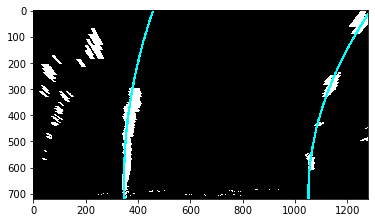

In [201]:
# plt.imshow(rightLaneTfm)
plt.imshow(newimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


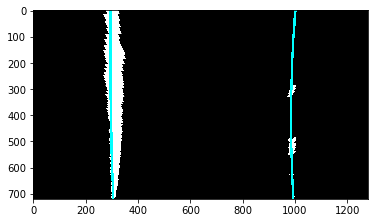

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


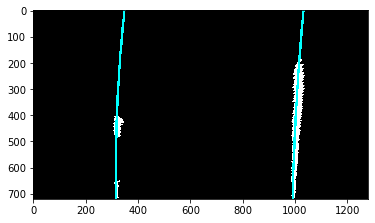

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


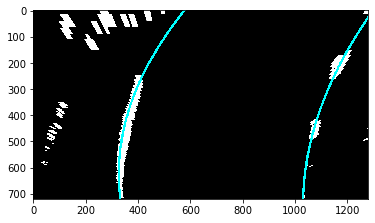

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


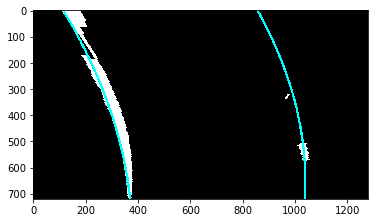

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


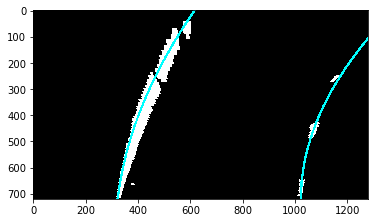

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


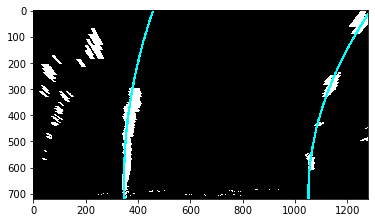

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


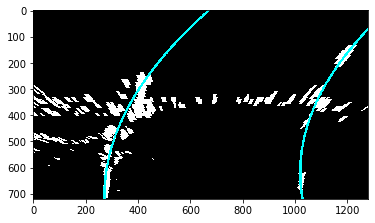

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


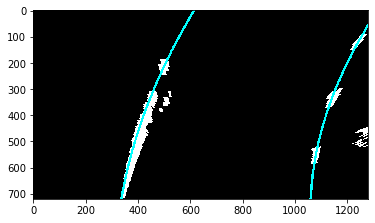

In [205]:
# img = mpimg.imread("./test_images/straight_lines1.jpg")
for i in os.listdir("./test_images/"):
    img = mpimg.imread("./test_images/" + i)

    imgn = imgHandler(img)

    # both = cv2.addWeighted(rightOrth, 1, leftOrth, 1, 0)

    # Create a list of "line" objects for cv2.polyLines() to use
    # newimg = makeLineFitOverlay(both, leftLaneFit, rightLaneFit)
    plt.imshow(imgn)
    plt.show()

### Get project deliverables
#### Undistort a sample calibration image & demo image pipeline on all test images
All test images shown in notebook and saved to file in "./output_images/"

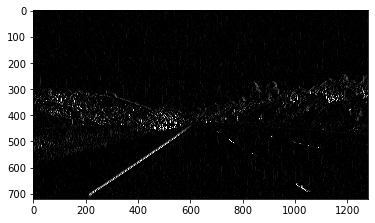

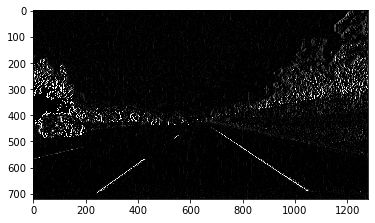

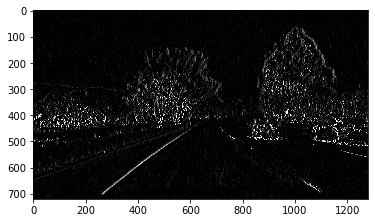

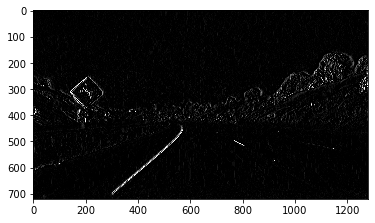

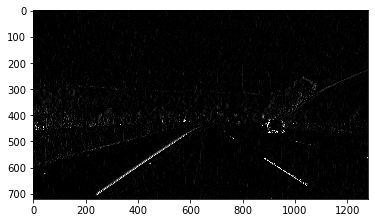

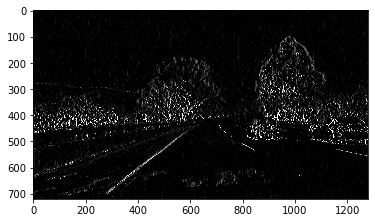

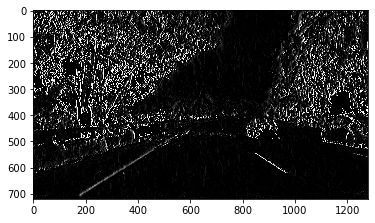

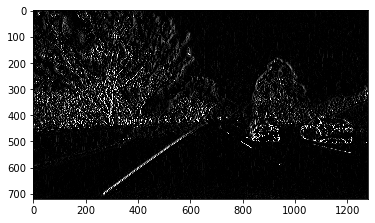

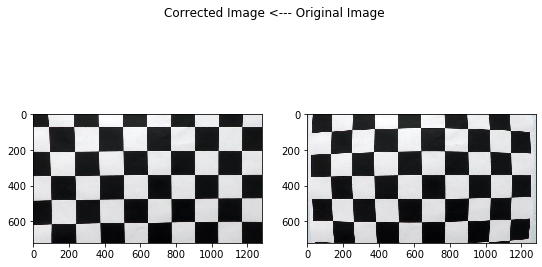

In [22]:
# Fulfill distortion comparison deliverable
imageUndistortRoutine("./camera_cal/calibration1.jpg", "./output_images/calibration1.pdf", camMat, distortMat)

# Execute video processing on test videos of interest
# outputPath = "./test_videos_output/project_video_output.mp4"
# inputPath = "./project_video.mp4"

# alteredVid = vidProcRoutine(inputPath, outputPath, imgHandler)


### Video Pipeline Test

In [125]:
vidProcRoutine("./challenge_video.mp4", "./test_videos_output/challenge_video_ortholanes.mp4", imgHandler)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]Moviepy - Building video ./test_videos_output/challenge_video_ortholanes.mp4.
Moviepy - Writing video ./test_videos_output/challenge_video_ortholanes.mp4


t:   3%|▎         | 15/485 [00:04<02:12,  3.54it/s, now=None]

TypeError: expected non-empty vector for x